### 1993: Stochastic volatility model by Heston

The Heston model is a useful model for simulating stochastic volatility and its effect on the potential paths an asset can take over the life of an option.
 - Popular because of easy closed-form solution for European option pricing
 - no risk of negative variances
 - incorporation of leverage effect

This allows for more effective modeling than the Black-Scholes formula allows due to its restrictive assumption of constant volatility.

### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

<center>$\large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$</center>
    
<center>$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$</center>

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$


Dynamics under risk-neutral measure $\mathbb{Q}$:

<center>$\large dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$</center>
    
<center>$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$</center>

#### Euler Discretisation of SDEs

<center>$\Large dS_{i+1} = S_i e^{(r-\frac{v_i}{2}) \Delta t + \sqrt{v_{i}}\Delta tW^\mathbb{Q}_{S,i+1}}$</center>
    
<center>$\large v_{i+1} = v_i + \kappa(\theta - v_t)\Delta t +\sigma \sqrt{v_i} \Delta t W^\mathbb{Q}_{v,i+1}$</center>

In [1]:
!pip install py_vollib_vectorized

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.5 MB/s eta 0:00:00
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=1e49bed583d85c1193d929eedceb4bed856a205dd0a492c2daa24542848f1596
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=8bc08be569c3bb0d96a3e5d5c7b8f9587c6f10962e2061f650fee395c415c4c6
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py-vollib py-lets-be-rational


#### Import Dependencies

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

/usr/local/lib/python3.10/dist-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


#### Define Parameters
Here we just define the parameters of the model under risk-neutral dynamics, however in a following tutorial I will show how to calibrate Heston model parameters under risk-neutral dynamics to real option market prices.

In [12]:
# Parameters
# simulation dependent
S0 = 100.0 # asset price
T = 1.0    # time in years
r = 0.02   # risk-free rate
N = 252    # number of time steps in simulation
M = 1000   # number of simulations

# Heston dependent parameters
kappa = 3       # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2 # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2    # initial variance under risk-neutral dynamics
rho = 0.7       # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6     # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

#### Monte Carlo Simulation
Because we have a recursive function, we have to step through time within our simulation. However we can simulate the Brownian motions of the asset and variances outside of the for loop.

In [4]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S, v

In [5]:
rho_p = 0.98
rho_n = -0.98

S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

#### Plotting the asset prices and variance over time

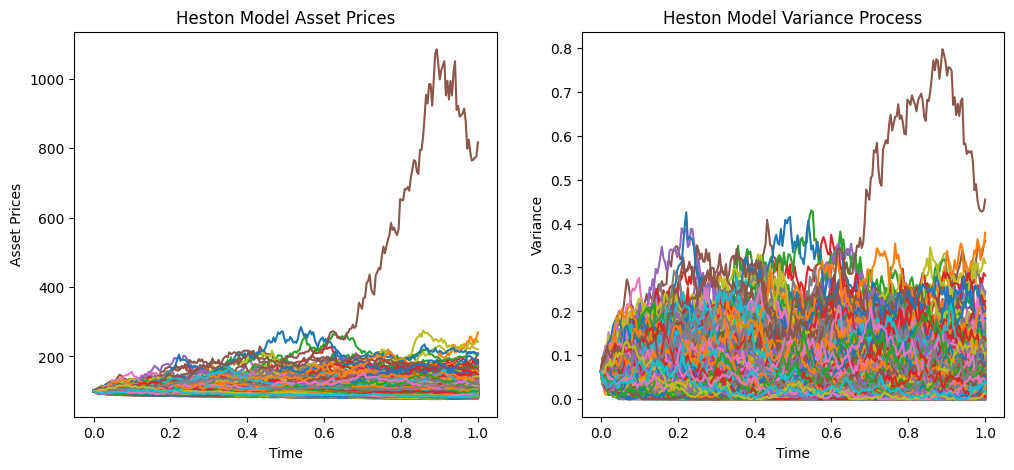

In [6]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

### Asset price distribution with different correlations

In [7]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

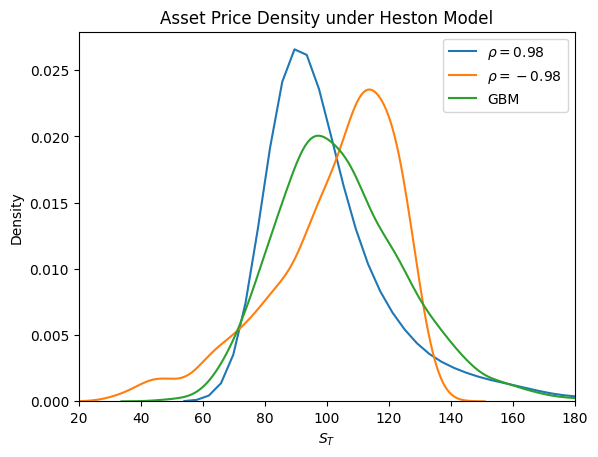

In [8]:
fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Capturing the Volatililty Smile in Option Pricing

In [9]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

In [10]:
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

/usr/local/lib/python3.10/dist-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


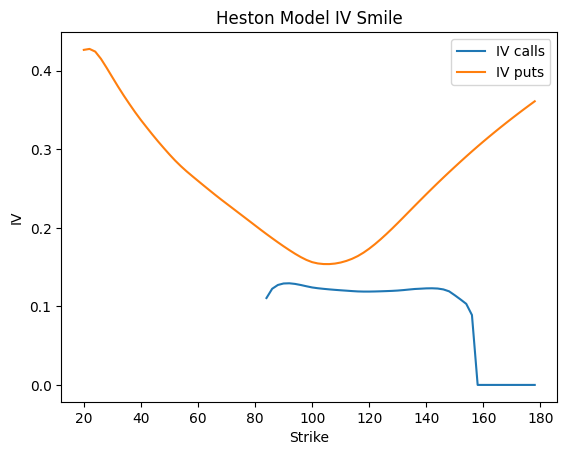

In [13]:
plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('IV')
plt.xlabel('Strike')

plt.title('Heston Model IV Smile')
plt.legend()
plt.show()